In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from tqdm.notebook import tqdm
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

### Massive type IIA on $S^3\times S^3$

Scanning over the parameters ($u_0,\phi_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [00:13<00:00, 66.08it/s] 


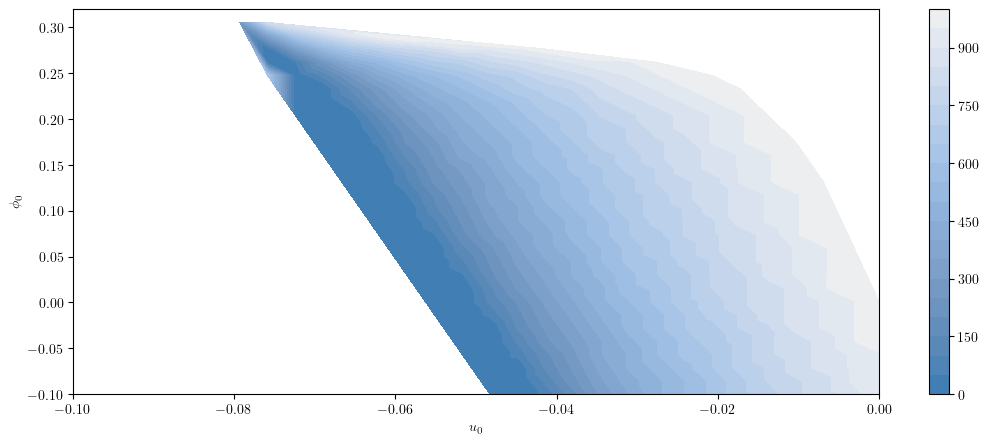

In [107]:
wh.paramScan_S3S3(1, 10, [-0.1, 0], [-0.1, 0.32], 30, 30)

Example profiles upon picking ($u_0,\phi_0$) by hand:

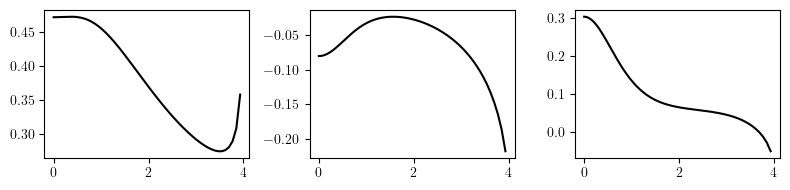

In [109]:
q0, rmax = 1, 10
u0, φ0 = -0.0802, 0.304
soln = wh.solve_S3S3(q0, rmax, u0, φ0)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 out to r = 10 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 98
            u0 : -0.07570750404
            φ0 : +0.2679907332
           val : 1.07982886e-08
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 47
            u0 : -0.07891023104
            φ0 : +0.2942145175
           val : 5.982180773e-08
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 137
            u0 : -0.07891872148
            φ0 : +0.2943215978
           val : 0


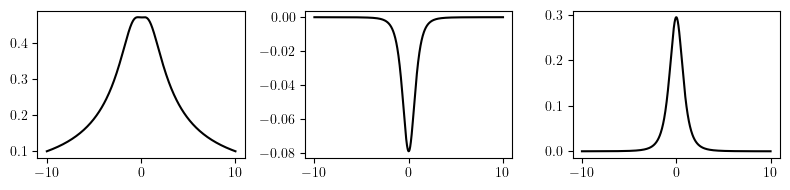

In [147]:
q0, rmax = 1, 10
soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-10)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2), sharex=True)

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

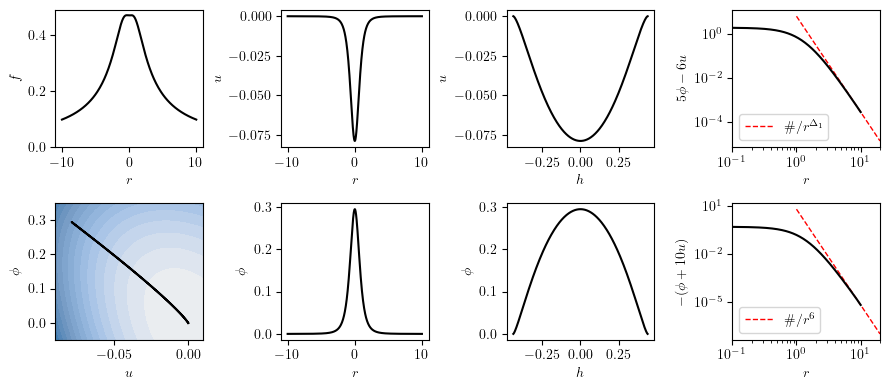

In [112]:
fig, axes = plt.subplots(2, 4, figsize=(9,4))

q = wh.Q(r, q0)

xdata = [r, r, h, r, u, r, h, r]
ydata = [f, u, u, 5*φ-6*u, φ, φ, φ, -(φ+10*u)]
xlabels = ['$r$', '$r$', '$h$', '$r$', '$u$', '$r$', '$h$', '$r$']
ylabels = ['$f$', '$u$', '$u$', '$5\phi-6u$', '$\phi$', '$\phi$', '$\phi$', '$-(\phi+10u)$']


# Plot expected power-law fall-offs in asymptotic region
Δ1 = (3+np.sqrt(33))/2
fcoeff = np.mean(r[-10:]**2 * (f[-10:]**(-2) - (r[-10:]**2 + (1+2*q0**2))))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
uφcoeff2 = np.mean(r[-10:]**6 * (-φ[-10:] - 10*u[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[0,3].plot(rr, uφcoeff1/rr**Δ1, '--r', lw=1, label='$\#/r^{\Delta_1}$')
axes[1,3].plot(rr, uφcoeff2/rr**6, '--r', lw=1, label='$\#/r^6$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

# for ax in axes[0]:
#     ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])


for ax in axes[:,3]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()

# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

Field ranges (with comparison to _ad hoc_ replacement $\mathcal{V}\to-6$ where $u,\phi$ are massless):

In [149]:
q0s = np.geomspace(0.0001, 10, 20)

q0s_ml = np.geomspace(q0s[0], q0s[-1], 20)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, f4s_ml = data_ml.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-8)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), np.sqrt(f4sqr)])

u0s, φ0s, f4s = np.asarray(data).T


Performing shooting method for q0 = 0.0001 out to r = 10 ...
    rmax = 0.0001 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.261458267e-10
    rmax = 0.0316 with xatol = 0.0001
        f_eval : 79
            u0 : -0.782941184
            φ0 : +1.565915033
           val : 1.440308761e-09
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 118
            u0 : -0.7829423009
            φ0 : +1.565899692
           val : 1.532107774e-14

Performing shooting method for q0 = 0.00018329807108324357 out to r = 10 ...
    rmax = 0.0002 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.251988065e-10
    rmax = 0.0428 with xatol = 0.0001
        f_eval : 80
            u0 : -0.7829105945
            φ0 : +1.565812434
           val : 8.97369512e-10
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 116
            u0 : -0.7829072972
       

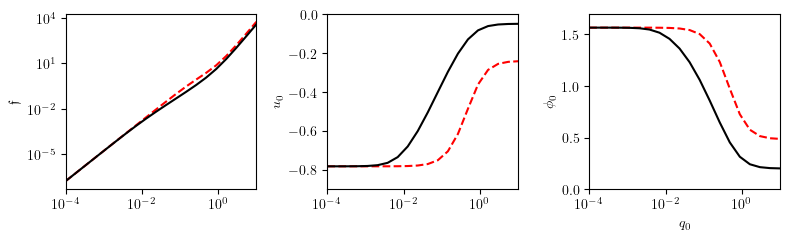

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), sharex=True)

axes[0].plot(q0s_ml, f4s_ml, '--r')
axes[0].plot(q0s, f4s, 'k', ms=3)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\mathfrak{f}$')

axes[1].plot(q0s_ml, u0s_ml, '--r')
axes[1].plot(q0s, u0s, 'k', ms=3)
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(q0s_ml, φ0s_ml, '--r')
axes[2].plot(q0s, φ0s, 'k', ms=3)
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

plt.tight_layout()
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

Flat-space limit


Performing shooting method for q0 = 1.0 out to r = 100 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 98
            u0 : -0.07570750404
            φ0 : +0.2679907332
           val : 1.07982886e-08
    rmax = 10.0000 with xatol = 0.0001
        f_eval : 75
            u0 : -0.07891541747
            φ0 : +0.2942800927
           val : 3.808220613e-06
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 192
            u0 : -0.07891872314
            φ0 : +0.2943216216
           val : 6.661338148e-16

Performing shooting method for q0 = 0.1 out to r = 100 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 113
            u0 : -0.2595244827
            φ0 : +0.6021362378
           val : 1.69582659e-09
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 92
            u0 : -0.359341949
            φ0 : +0.9822359592
           val : 2.120974448e-07
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 213
            u0 : -0.3593439707
            φ0 : +0.

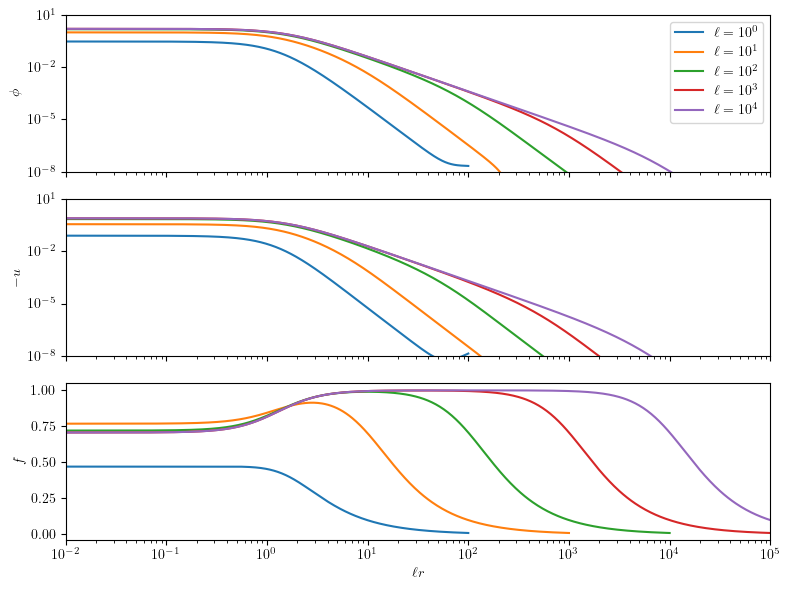

In [105]:
a0 = 1
powers = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 100
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-12)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$\ell=10^{}$'.format(power))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

### Type IIB on $T^{1,1}$

Scanning over the parameters ($u_0,v_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [01:26<00:00, 10.43it/s]


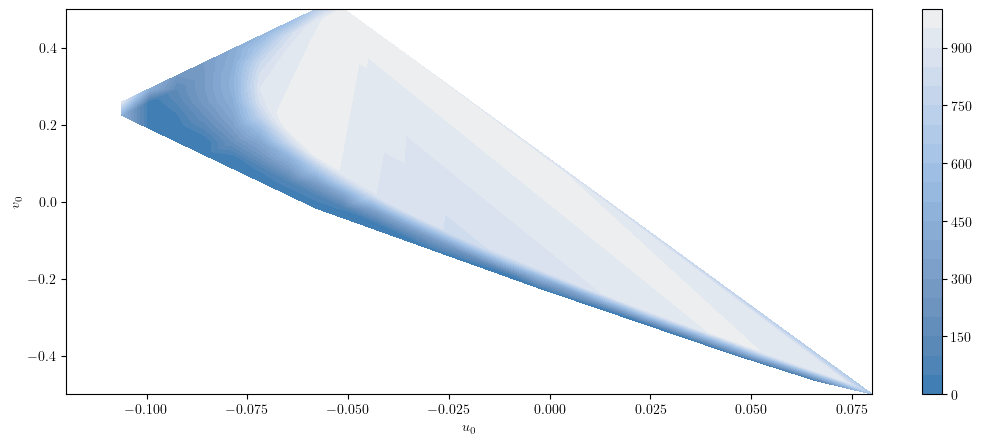

In [5]:
wh.paramScan_T11(1, 5, [-0.12, 0.08], [-0.5,0.5], 30, 30)

Example profiles upon picking ($u_0,v_0$) by hand (wlg, $\phi_0=0$):

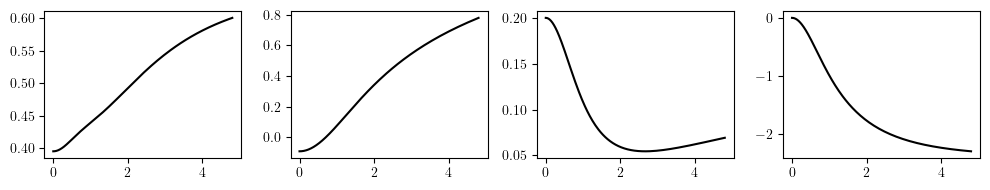

In [7]:
q0, rmax = 1, 5
u0, v0 = -0.09, 0.2
soln = wh.solve_T11(q0, rmax, u0, v0, 0)
r, f, u, ud, v, vd, φ, φd, h, f3sqr = soln

fig, axes = plt.subplots(1, 4, figsize=(10,2))

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, v, 'k')
axes[3].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 out to r = 10 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 104
            u0 : -0.09957659666
            v0 : +0.1697326255
           val : 2.359970142e-08
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 55
            u0 : -0.1030343401
            v0 : +0.1826934047
           val : 3.77686412e-07
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 273
            u0 : -0.1030304791
            v0 : +0.1826790316
           val : 0


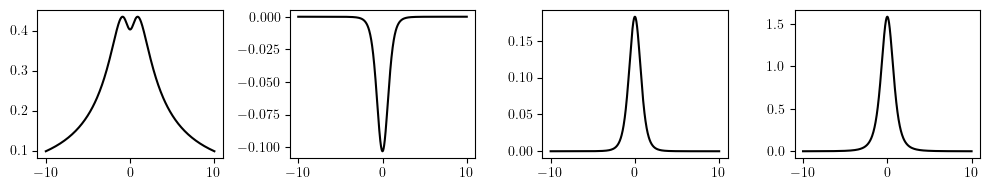

In [8]:
q0, rmax = 1, 10
soln = wh.wormhole_T11(q0, rmax, xatol=10**-10)
r, f, u, ud, v, vd, φ, φd, h, f3sqr = soln

fig, axes = plt.subplots(1, 4, figsize=(10,2))

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, v, 'k')
axes[3].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

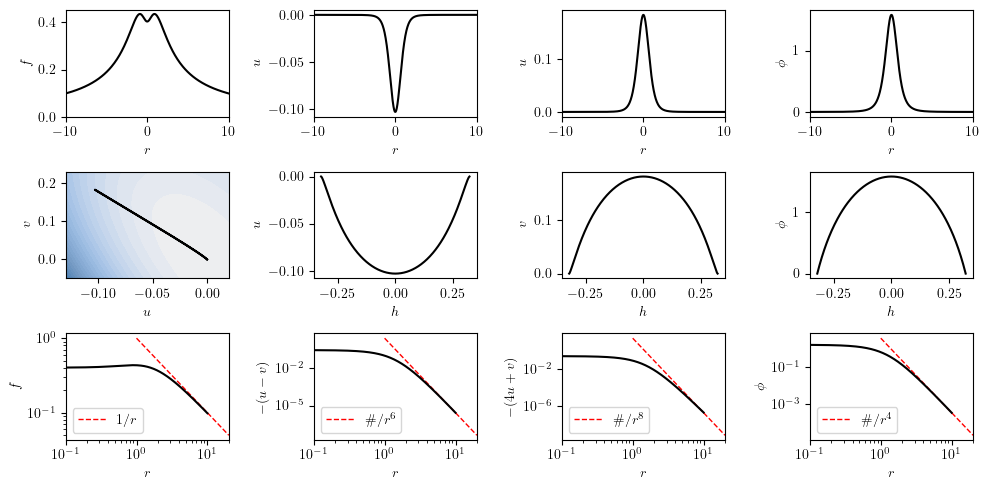

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(10,5))

xdata = [r, r, r, r, u, h, h, h, r, r, r, r]
ydata = [f, u, v, φ, v, u, v, φ, f, -(u-v), -(4*u+v), φ]
xlabels = ['$r$', '$r$', '$r$', '$r$', '$u$', '$h$', '$h$', '$h$', '$r$', '$r$', '$r$', '$r$']
ylabels = ['$f$', '$u$', '$u$', '$\phi$', '$v$', '$u$', '$v$', '$\phi$', '$f$', '$-(u-v)$', '$-(4u+v)$', '$\phi$']


# # Plot expected power-law fall-offs in asymptotic region
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]))
φcoeff = np.mean(r[-10:]**4 * φ[-10:])

rr = np.linspace(q0, 2*rmax, 2)
axes[2,0].plot(rr, 1/rr, '--r', lw=1, label='$1/r$')
axes[2,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[2,2].plot(rr, uvcoeff2/rr**8, '--r', lw=1, label='$\#/r^8$')
axes[2,3].plot(rr, φcoeff/rr**4, '--r', lw=1, label='$\#/r^4$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

for ax in axes[0]:
    ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.13, 0.02, 40)
v0s = np.linspace(-0.05, 0.23, 40)
umesh, vmesh = np.meshgrid(u0s, v0s)
VV = wh.V_T11(umesh, vmesh)

axes[1,0].contourf(umesh, vmesh, VV,
                   levels=np.arange(-12, 1, 0.5),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], v0s[0], v0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(v0s[0], v0s[-1])


for ax in axes[2]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

# axes[2,0].delete()

plt.tight_layout()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Field ranges (with comparison to _ad hoc_ changes to the potential where $u,v$ are frozen or massless):

In [14]:
q0s = np.geomspace(0.01, 10, 20)

q0s_ml = np.geomspace(0.7728, q0s[-1], 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0s_ml, v0s_ml, φ0s_ml, f3s_ml = data_ml.T

q0s_fr = np.geomspace(q0s[0], q0s[-1], 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0s_fr, v0s_fr, φ0s_fr, f3s_fr = data_fr.T

data = []

for q0 in q0s:

    rmax = max(30, 10*q0)
    soln = wh.wormhole_T11(q0, rmax, xatol=10**-10, nr=10000)
    r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

    # It happens that u<0 and v,φ>0. Extract also the 1/r^4 coefficient in φ
    #   for comparison with the BPS bound
    data.append([min(u), max(v), max(φ), np.sqrt(f3sqr), np.mean(r[-10:]**4 * φ[-10:])])

u0s, v0s, φ0s, f3s, φ4s = np.asarray(data).T


Performing shooting method for q0 = 0.01 out to r = 30 ...
    rmax = 0.0100 with xatol = 0.0001
        f_eval : 105
            u0 : -0.5541168712
            v0 : +0.5858398678
           val : 1.458690502e-09
    rmax = 0.5477 with xatol = 0.0001
        f_eval : 218
            u0 : -1.008048965
            v0 : +1.257172322
           val : 8.384649675e-08
    rmax = 30.0000 with xatol = 1e-10
        f_eval : 165
            u0 : -1.008050275
            v0 : +1.257205824
           val : 0.000168395973

Performing shooting method for q0 = 0.01438449888287663 out to r = 30 ...
    rmax = 0.0144 with xatol = 0.0001
        f_eval : 111
            u0 : -0.545160631
            v0 : +0.5794553907
           val : 6.736800007e-10
    rmax = 0.6569 with xatol = 0.0001
        f_eval : 191
            u0 : -0.9185285616
            v0 : +1.166475318
           val : 2.158910912e-07
    rmax = 30.0000 with xatol = 1e-10
        f_eval : 154
            u0 : -0.9185283122
            

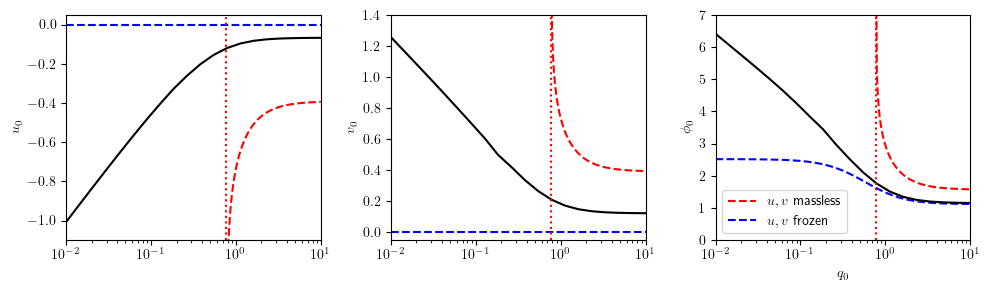

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True)

axes[0].plot(q0s_ml, u0s_ml, '--r')
axes[0].plot(q0s_fr, u0s_fr, '--b')
axes[0].plot(q0s, u0s, 'k')

axes[1].plot(q0s_ml, v0s_ml, '--r')
axes[1].plot(q0s_fr, v0s_fr, '--b')
axes[1].plot(q0s, v0s, 'k')

axes[2].plot(q0s_ml, φ0s_ml, '--r', label='$u,v$ massless')
axes[2].plot(q0s_fr, φ0s_fr, '--b', label='$u,v$ frozen')
axes[2].plot(q0s, φ0s, 'k')

for ax, ylab in zip(axes, ['$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(q0s_ml[0], ls=':', c='r')
    ax.set_ylabel(ylab)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

axes[0].set_ylim(-1.1, 0.05)
axes[1].set_ylim(-0.05, 1.4)
axes[2].set_ylim(0, 7)

axes[2].legend()

plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

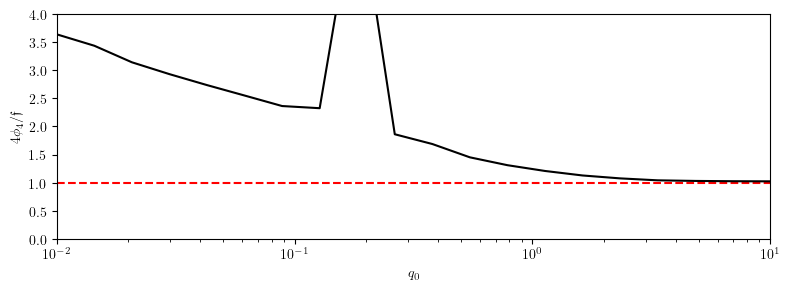

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

plt.axhline(1, ls='--', c='r')

plt.plot(q0s, 4*φ4s/f3s, 'k')

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

plt.ylim(0, 4)
plt.ylabel('$4\phi_4/\mathfrak{f}$')

plt.tight_layout()
# plt.savefig('T11_BPS.png', dpi=300)
plt.show()


Performing shooting method for q0 = 0.5 out to r = 50 ...
    rmax = 0.5000 with xatol = 0.0001
        f_eval : 106
            u0 : -0.1559952164
            v0 : +0.2465858505
           val : 1.144547424e-08
    rmax = 5.0000 with xatol = 0.0001
        f_eval : 70
            u0 : -0.1655201244
            v0 : +0.2808297174
           val : 9.706047054e-06
    rmax = 50.0000 with xatol = 1e-12
        f_eval : 327
            u0 : -0.1655181198
            v0 : +0.2808155454
           val : 0
2.341705660238049 2.3417056390787407


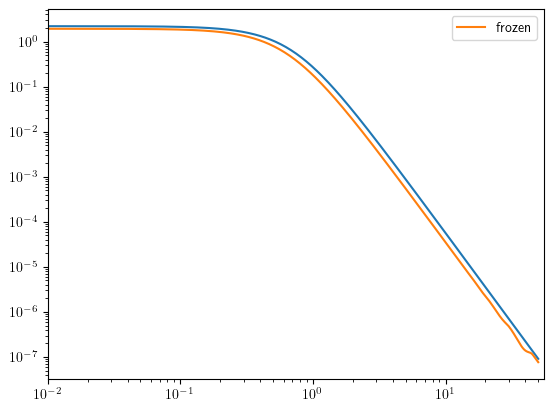

In [355]:
q0 = 0.5
q0_fr = 0.47553869
rmax = 50

soln = wh.wormhole_T11(q0, rmax, xatol=10**-12)
r, f, u, ud, v, vd, φ, φd, h, f3sqr = soln

soln_fr = wh.wormhole_frozen_T11(q0_fr, rmax)
r_fr, f_fr, u_fr, ud_fr, v_fr, vd_fr, φ_fr, φd_fr, h_fr, f3sqr_fr = soln_fr

print(f3sqr, f3sqr_fr)

plt.plot(r, φ)
plt.plot(r_fr, φ_fr, label='frozen')

plt.xlim(0.01)
# plt.ylim(10**-8, 10)
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

Flat-space limit


Performing shooting method for q0 = 1.0 out to r = 100 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 104
            u0 : -0.09957659666
            v0 : +0.1697326255
           val : 2.359970142e-08
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 55
            u0 : -0.1030343401
            v0 : +0.1826934047
           val : 3.77686412e-07
    rmax = 10.0000 with xatol = 0.0001
        f_eval : 85
            u0 : -0.1030340309
            v0 : +0.1826984722
           val : 1.872876261e-05
    rmax = 31.6228 with xatol = 0.0001
        f_eval : 120
            u0 : -0.1030339994
            v0 : +0.1826990025
           val : 0.001073734209
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 182
            u0 : -0.1030339978
            v0 : +0.1826990286
           val : 0.3504661312

Performing shooting method for q0 = 0.01 out to r = 100 ...
    rmax = 0.0100 with xatol = 0.0001
        f_eval : 105
            u0 : -0.5541168712
            v0 : +0.58

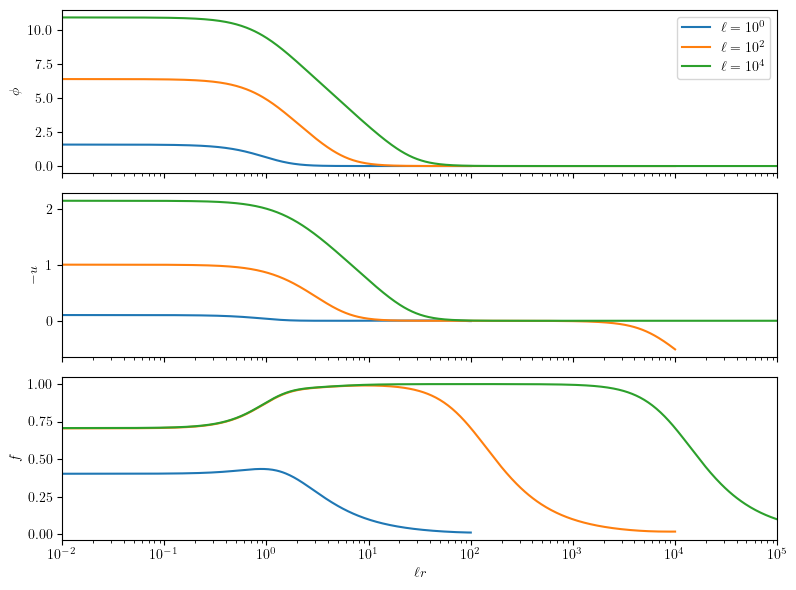

In [193]:
a0 = 1
powers = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 100
    soln = wh.wormhole_T11(q0, rmax, xatol=10**-12, rmax_steps=5)
    r, f, u, ud, v, vd, φ, φd, h, f4sqr = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$\ell=10^{}$'.format(power))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10**3)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10**3)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
# plt.savefig('images/T11_flat_limit.png', dpi=300)
plt.show()